In [174]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

In [175]:
split_layer = 2
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [3]:
for batch in trainloader:
    print(batch[0].shape)
    break

torch.Size([64, 1, 28, 28])


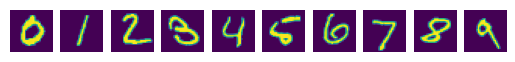

In [27]:
ims = [get_examples_by_class(testset, c, count=1) for c in range(10)]
display_imagelist(ims, 28, 28)

In [32]:
ims  = torch.vstack(ims)

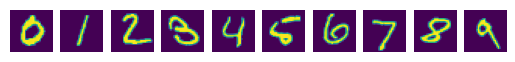

In [36]:
display_imagelist(ims, 28, 28)

In [37]:
ims.shape

torch.Size([10, 28, 28])

In [47]:
Q = torch.nn.utils.parametrizations.orthogonal(nn.Linear(28, 28))

In [48]:
ims_changed =  ims @ Q.weight

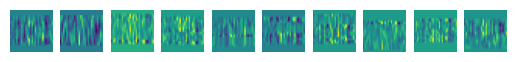

In [51]:
display_imagelist(ims_changed, 28, 28)

In [52]:
ims_reverse_changed = ims_changed @ Q.weight.T

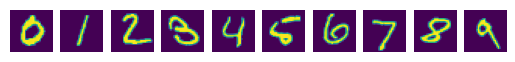

In [53]:
display_imagelist(ims_reverse_changed, 28, 28)

training loop with defense

In [60]:
U = torch.nn.utils.parametrizations.orthogonal(nn.Linear(28, 28))

In [66]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images = images @ U.weight
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.30388814210891724 Acc: 96.77771709448389
Epoch: 1 Loss: 0.08129306137561798 Acc: 97.49443207126949
Epoch: 2 Loss: 0.05887492746114731 Acc: 98.45814977973568
Epoch: 3 Loss: 0.04649188369512558 Acc: 98.25613079019074
Epoch: 4 Loss: 0.037321340292692184 Acc: 98.7736900780379
Epoch: 5 Loss: 0.03134052827954292 Acc: 98.44444444444444
Epoch: 6 Loss: 0.02648414671421051 Acc: 98.57690202517789
Epoch: 7 Loss: 0.021827202290296555 Acc: 98.46238330587589
Epoch: 8 Loss: 0.018923737108707428 Acc: 98.63462588749317
Epoch: 9 Loss: 0.01673857308924198 Acc: 98.85057471264368


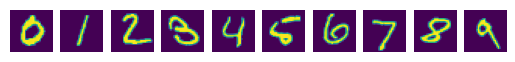

In [176]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

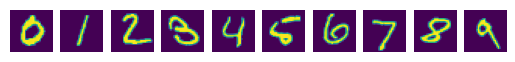

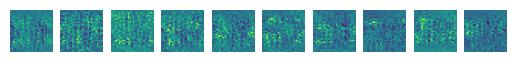

In [63]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    target = target @ U.weight
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

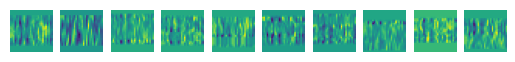

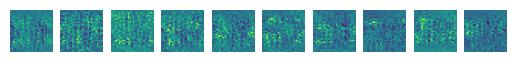

In [65]:
display_imagelist(torch.vstack(inversion_targets) @ U.weight, 28, 28)
display_imagelist(results, 28, 28)

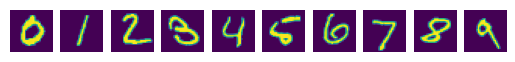

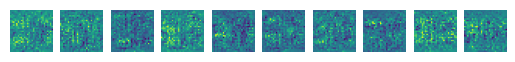

In [67]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    target = target @ U.weight
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## different models on server and client sides

In [87]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images = images @ U.weight
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=3), start=4)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.2958889305591583 Acc: 18.500273672687467
Epoch: 1 Loss: 0.07387958467006683 Acc: 16.97699890470975
Epoch: 2 Loss: 0.051842834800481796 Acc: 13.571428571428571
Epoch: 3 Loss: 0.040450260043144226 Acc: 10.828729281767956
Epoch: 4 Loss: 0.03268313780426979 Acc: 16.50110375275938
Epoch: 5 Loss: 0.027718735858798027 Acc: 15.447598253275109
Epoch: 6 Loss: 0.02290348708629608 Acc: 13.721185510428102
Epoch: 7 Loss: 0.0202036090195179 Acc: 14.22271223814774
Epoch: 8 Loss: 0.01696529984474182 Acc: 13.504647348277748
Epoch: 9 Loss: 0.014761434867978096 Acc: 9.70556161395856


In [ ]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
with torch.no_grad():
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            #client_opt.zero_grad()
            #server_opt.zero_grad()

            #pred = server(client(images, end=split_layer), start=split_layer+1)
            print(images.shape)
            print(client(images, end=6).shape)
            print(client(images, end=6))
            print(server(client(images, end=6), start=7).shape)
            print(server(client(images, end=6), start=7))

            loss = criterion(pred, labels)
            loss.backward()
            running_loss += loss

            #server_opt.step()
            #client_opt.step()
            break
        else:
            print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')
        break


In [177]:
import math

class DefenseLayer(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, input_dim, output_dim, U):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.empty(input_dim, output_dim), requires_grad=True)
        self.U = U

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        torch.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    def forward(self, input):
        #return input @ self.U.weight.T.detach() @ self.weight
        output = torch.matmul(torch.matmul(input, self.U.weight.T), self.weight)
        assert output.requires_grad, "Output should have requires_grad=True"
        return output

In [178]:
class MnistNetWithOrthogonalDefense(nn.Module):
    def __init__(self, U, n_channels=1):
        super(MnistNetWithOrthogonalDefense, self).__init__()
        self.features = []
        self.initial = None
        self.classifier = []
        self.layers = collections.OrderedDict()

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=8, kernel_size=5)
        self.features.append(self.conv1) #0
        self.layers["conv1"] = self.conv1

        self.ReLU1 = nn.ReLU(False)
        self.features.append(self.ReLU1) #1
        self.layers["ReLU1"] = self.ReLU1

        self.pool1 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool1) #2
        self.layers["pool1"] = self.pool1

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.features.append(self.conv2) #3
        self.layers["conv2"] = self.conv2

        self.ReLU2 = nn.ReLU(False)
        self.features.append(self.ReLU2) #4
        self.layers["ReLU2"] = self.ReLU2

        self.pool2 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool2) #5
        self.layers["pool2"] = self.pool2

        self.feature_dims = 16 * 4 * 4
        #self.fc1 = nn.Linear(self.feature_dims, 120) #start=6
        self.fc1 = DefenseLayer(self.feature_dims, 120, U) #start=6
        self.classifier.append(self.fc1)
        self.layers["fc1"] = self.fc1

        # adjusted layers
        #self.defense = DefenseLayer(120, 120, U) #start=7
        #self.classifier.append(self.defense)
        #self.layers["defense"] = self.defense
        # end of adjusted layers

        self.fc1act = nn.ReLU(False)
        self.classifier.append(self.fc1act)
        self.layers["fc1act"] = self.fc1act

        self.fc2 = nn.Linear(120, 84)
        self.classifier.append(self.fc2)
        self.layers["fc2"] = self.fc2

        self.fc2act = nn.ReLU(False)
        self.classifier.append(self.fc2act)
        self.layers["fc2act"] = self.fc2act

        self.fc3 = nn.Linear(84, 10)
        self.classifier.append(self.fc3)
        self.layers["fc3"] = self.fc3

        self.initial_params = [
            param.clone().detach().data for param in self.parameters()
        ]

    def forward(self, x, start=0, end=10):
        if start <= 5:  # start in self.features
            for idx, layer in enumerate(self.features[start:]):
                x = layer(x)
                if idx == end:
                    return x
            x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                x = layer(x)
                if idx + 6 == end:
                    return x
        else:
            #if start >5:
            #    x = x.view(-1, self.feature_dims)
            #for idx, layer in enumerate(self.classifier):
            #    if idx >= start - 6:
            #        x = layer(x)
            #    if idx + 6 == end:
            #        return x
            if start == 6:
                x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                if idx >= start - 6:
                    x = layer(x)
                if idx + 6 == end:
                    return x

    def get_params(self, end=10):
        params = []
        for layer in list(self.layers.values())[: end + 1]:
            params += list(layer.parameters())
        return params

    def restore_initial_params(self):
        for param, initial in zip(self.parameters(), self.initial_params):
            param.data = initial.requires_grad_(True)

In [106]:
U = torch.nn.utils.parametrizations.orthogonal(nn.Linear(120, 120))

In [190]:
U = torch.nn.utils.parametrizations.orthogonal(nn.Linear(256, 256))

In [180]:
client, server, clone = MnistNetWithOrthogonalDefense(U), MnistNetWithOrthogonalDefense(U), MnistNetWithOrthogonalDefense(U)

In [149]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images = images @ U.weight
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.2871337831020355 Acc: 96.32675438596492
Epoch: 1 Loss: 0.08980734646320343 Acc: 97.90518191841235
Epoch: 2 Loss: 0.06724649667739868 Acc: 98.36601307189542
Epoch: 3 Loss: 0.05599716305732727 Acc: 98.56670341786108
Epoch: 4 Loss: 0.047846000641584396 Acc: 98.17073170731707
Epoch: 5 Loss: 0.041816480457782745 Acc: 99.0695128626163
Epoch: 6 Loss: 0.039435241371393204 Acc: 98.3013698630137
Epoch: 7 Loss: 0.03491736203432083 Acc: 98.90650628758884
Epoch: 8 Loss: 0.031026361510157585 Acc: 98.2957669048928
Epoch: 9 Loss: 0.029456935822963715 Acc: 99.45115257958288


In [181]:
client, server, clone = MnistNetWithOrthogonalDefense(U), MnistNetWithOrthogonalDefense(U), MnistNet()

In [160]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images = images @ U.weight
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2543477.0 Acc: 79.26695842450766
Epoch: 1 Loss: 0.5565747022628784 Acc: 85.61230093355299
Epoch: 2 Loss: 0.4416942894458771 Acc: 86.53846153846153
Epoch: 3 Loss: 0.38354605436325073 Acc: 89.35589519650655
Epoch: 4 Loss: 0.3427603542804718 Acc: 90.49450549450549
Epoch: 5 Loss: 0.31210485100746155 Acc: 90.69003285870755
Epoch: 6 Loss: 0.2920006215572357 Acc: 92.0238741182854
Epoch: 7 Loss: 0.276864230632782 Acc: 91.77043854899837
Epoch: 8 Loss: 0.26505690813064575 Acc: 90.79452054794521
Epoch: 9 Loss: 0.2559409737586975 Acc: 91.74917491749174


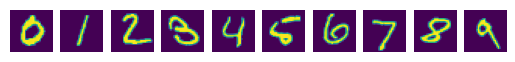

In [161]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()
display_imagelist(inversion_targets, 28, 28)

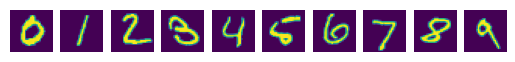

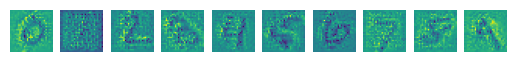

In [162]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    #target = target @ U.weight
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

now we will increase the SPLIT_LAYER

In [194]:
split_layer = 6

In [195]:
client, server, clone = MnistNetWithOrthogonalDefense(U), MnistNetWithOrthogonalDefense(U), MnistNet()

In [196]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images = images @ U.weight
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.2777460515499115 Acc: 96.73202614379085
Epoch: 1 Loss: 0.09188045561313629 Acc: 97.28555917480999
Epoch: 2 Loss: 0.07204099744558334 Acc: 97.82135076252723
Epoch: 3 Loss: 0.057871896773576736 Acc: 98.51239669421487
Epoch: 4 Loss: 0.05160053074359894 Acc: 98.51729818780889
Epoch: 5 Loss: 0.04470577836036682 Acc: 98.7431693989071
Epoch: 6 Loss: 0.040102340281009674 Acc: 97.97814207650273
Epoch: 7 Loss: 0.03836461901664734 Acc: 98.56749311294766
Epoch: 8 Loss: 0.0318073108792305 Acc: 98.73834339001645
Epoch: 9 Loss: 0.030951904132962227 Acc: 99.12472647702407


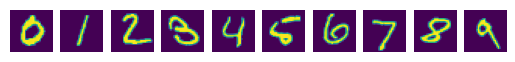

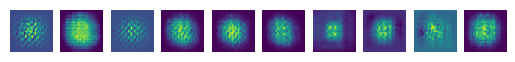

In [197]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    #target = target @ U.weight
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)